In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10/data_batch_1
/kaggle/input/cifar10/data_batch_2
/kaggle/input/cifar10/batches.meta
/kaggle/input/cifar10/test_batch
/kaggle/input/cifar10/data_batch_3
/kaggle/input/cifar10/data_batch_5
/kaggle/input/cifar10/data_batch_4


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torchvision

In [4]:
import torch.nn.functional as F

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


train_batch = {}
test_batch = unpickle('/kaggle/input/cifar10/test_batch')
for i in range(5):
    train_batch[f'batch_{i+1}'] = unpickle("/kaggle/input/cifar10/data_batch_%d"%(i + 1))

In [6]:
def get_dataset(batch_dict,test_dict):


    training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
    training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.tensor(batch_dict['batch_5'][b'labels']))))     

    test_images = torch.tensor(test_dict[b'data'],dtype = torch.float32)
    test_labels = torch.tensor(test_dict[b'labels'])

    training_image = training_image.view(50000,3,32,32)
    test_images = test_images.view(test_images.shape[0],3,32,32)

    return training_image,training_labels,test_images,test_labels


def make_batches(batch_size=16):
    training_image,training_labels,test_images,test_labels = get_dataset(train_batch,test_batch)
    train_dataset = TensorDataset(training_image,training_labels)
    test_dataset = TensorDataset(test_images,test_labels)
    train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    test_loader = DataLoader(test_dataset,shuffle =True,batch_size=batch_size)

    return train_loader,test_loader

In [7]:

def training(model,criterion,optimizer,train_loader,epochs=10,device='cuda'):
    training_losses = []
    running_loss = 0.0
    training_accuracy = 0
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_loader):
            images= images.to(device)
            labels = labels.to(device)
            output = model(images)

            loss = criterion(output,labels)
            running_loss += loss.item()
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            _, predicted = torch.max(output.data, 1)

            training_accuracy += (predicted == labels).sum().item()
            if ((i+1)%100 == 0):
                print(f'epoch:{epoch + 1},loss:{loss.item():.4f}')
                
        avg_train_loss = running_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        print(f'accuracy:{training_accuracy*100/50000}')
        training_accuracy = 0    

#     torch.save(model.state_dict(),'/kaggle/working/model.pth')

    return training_losses

In [8]:
def evaluation(model,test_loader,device='cuda'):
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        n_correct = 0
        n_samples = 0
        test_loss = 0.0
        test_accuracy = 0
        for i,(images, labels) in enumerate(test_loader):
            images= images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        acc = 100.0 * n_correct / n_samples
        
        
        avg_test_loss = test_loss / len(test_loader.dataset)
        print(f'Accuracy of the network on the 10000 test images: {acc} %')
        
        return all_predictions,all_labels,avg_test_loss

In [9]:
def draw_matrix(all_predictions,all_labels):
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [10]:
train_loader,test_loader = make_batches(128)


/tmp/ipykernel_26/3786781395.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
/tmp/ipykernel_26/3786781395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.tenso

In [11]:
class ConvBN(nn.Module):
    
    def __init__(self,input_channels,filters,strides = 1,kernel_size = 3,padding = 1,rate = 0.25,drop = False):
        super(ConvBN,self).__init__()
        self.drop = drop
        self.conv = nn.Conv2d(input_channels,filters,kernel_size = kernel_size,padding = padding,stride = strides)
        self.bnorm = nn.BatchNorm2d(filters)
#         self.dropout = nn.dropout(rate)
        
    def forward(self,inputs):
        
        output = self.conv(inputs)
        
        output = F.relu(self.bnorm(output))
        
#         if self.drop:
#             output = self.droupout(output)
            
        return output
        

In [12]:
class VGG16(nn.Module):
    
    def __init__(self):
        super(VGG16,self).__init__()
        
        self.conv1 = ConvBN(3,64)
        self.conv2 = ConvBN(64,64)
        
        self.conv3 = ConvBN(64,128)
        self.conv4 = ConvBN(128,128)
        
        self.conv5 = ConvBN(128,256)
        self.conv6 = ConvBN(256,256)
        self.conv7 = ConvBN(256,256)
        
        self.conv8 = ConvBN(256,512)
        self.conv9 = ConvBN(512,512)
        self.conv10 = ConvBN(512,512)
        
        self.conv11 = ConvBN(512,512)
        self.conv12 = ConvBN(512,512)
        self.conv13 = ConvBN(512,512)
        
        
        self.fc1 = nn.Linear(512,512)
        self.fc2 = nn.Linear(512,10)
    
        self.maxpool = nn.MaxPool2d(2,2)
        self.batchnorm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.maxpool(self.conv2(x))
        
        x = self.conv3(x)
        x = self.maxpool(self.conv4(x))
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool(self.conv7(x))
        
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.maxpool(self.conv10(x))
        
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.maxpool(self.conv13(x))
        
        x = self.dropout(x)
        
        x = x.view(x.shape[0],512*1*1)
        
        x = self.fc1(x)
        
        x = self.batchnorm(x)
        
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x 
        
        

In [13]:
model = VGG16()

In [14]:
device= 'cuda'

In [15]:
model.to(device)

VGG16(
  (conv1): ConvBN(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvBN(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvBN(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): ConvBN(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): ConvBN(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv6): ConvB

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)

In [17]:
training_losses = training(model,criterion,optimizer,train_loader,epochs = 15)

epoch:1,loss:1.7787
epoch:1,loss:1.5516
epoch:1,loss:0.9911
accuracy:44.95
epoch:2,loss:0.7986
epoch:2,loss:0.9942
epoch:2,loss:0.8715
accuracy:68.986
epoch:3,loss:0.7784
epoch:3,loss:0.6359
epoch:3,loss:0.6971
accuracy:77.19
epoch:4,loss:0.3646
epoch:4,loss:0.5728
epoch:4,loss:0.4831
accuracy:82.368
epoch:5,loss:0.3690
epoch:5,loss:0.4370
epoch:5,loss:0.3304
accuracy:85.806
epoch:6,loss:0.4095
epoch:6,loss:0.3920
epoch:6,loss:0.2826
accuracy:88.73
epoch:7,loss:0.2878
epoch:7,loss:0.3441
epoch:7,loss:0.3977
accuracy:90.726
epoch:8,loss:0.1110
epoch:8,loss:0.4075
epoch:8,loss:0.1855
accuracy:92.566
epoch:9,loss:0.0978
epoch:9,loss:0.1761
epoch:9,loss:0.2823
accuracy:94.438
epoch:10,loss:0.1967
epoch:10,loss:0.2289
epoch:10,loss:0.1242
accuracy:95.312
epoch:11,loss:0.0943
epoch:11,loss:0.1045
epoch:11,loss:0.1183
accuracy:96.152
epoch:12,loss:0.0288
epoch:12,loss:0.1218
epoch:12,loss:0.1039
accuracy:97.282
epoch:13,loss:0.1278
epoch:13,loss:0.1814
epoch:13,loss:0.0549
accuracy:97.282
epo

In [18]:
all_predictions,all_labels,test_loss = evaluation(model,test_loader)

Accuracy of the network on the 10000 test images: 83.29 %


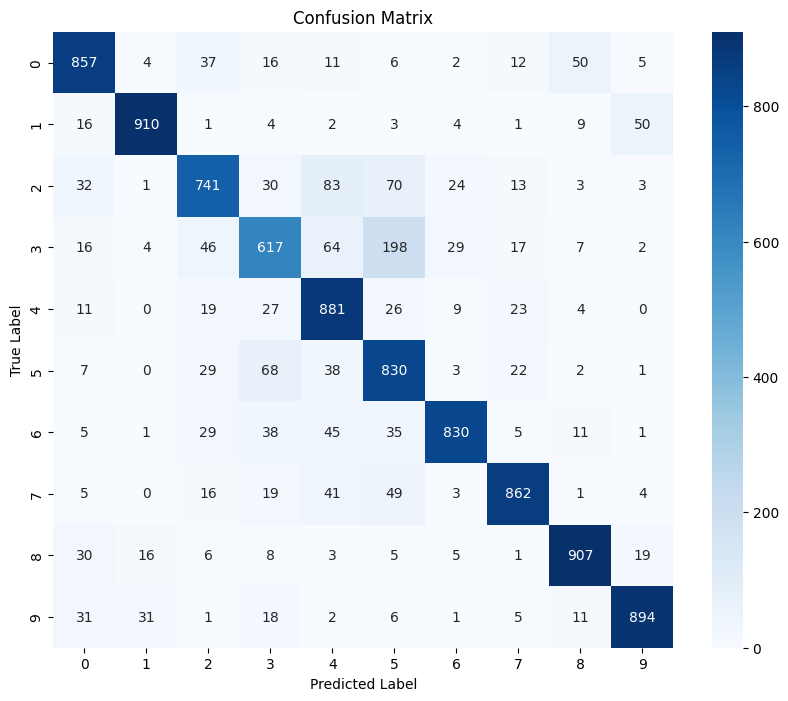

In [21]:
draw_matrix(all_predictions,all_labels)